<a href="https://colab.research.google.com/github/ftcelepcikay/NLP-in-Tensorflow/blob/master/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [0]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
# FTC: last element is label.
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-04-30 12:40:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.112, 2607:f8b0:4007:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-04-30 12:40:33 (113 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:
model = Sequential()
# FTC: Note that input_length=max_sequence_len-1. Because the last elem is label.
model.add(Embedding(total_words,100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.25))
model.add(LSTM(75))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 75)                112800    
_________________________________________________________________
dense (Dense)                (None, 1605)              121980    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,013,946
Trainable params: 6,013,946
Non-trainable params: 0
______________________________________________

In [0]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 6s 13ms/step - loss: 6.8926 - accuracy: 0.0219
Epoch 2/100
484/484 [==============================] - 6s 13ms/step - loss: 6.4987 - accuracy: 0.0229
Epoch 3/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3861 - accuracy: 0.0255
Epoch 4/100
484/484 [==============================] - 6s 13ms/step - loss: 6.2637 - accuracy: 0.0314
Epoch 5/100
484/484 [==============================] - 6s 13ms/step - loss: 6.1815 - accuracy: 0.0355
Epoch 6/100
484/484 [==============================] - 6s 13ms/step - loss: 6.1049 - accuracy: 0.0385
Epoch 7/100
484/484 [==============================] - 6s 13ms/step - loss: 6.0274 - accuracy: 0.0413
Epoch 8/100
484/484 [==============================] - 6s 13ms/step - loss: 5.9537 - accuracy: 0.0446
Epoch 9/100
484/484 [==============================] - 6s 13ms/step - loss: 5.8672 - accuracy: 0.0482
Epoch 10/100
484/484 [==============================] - 6s 13ms/step - loss: 5.765

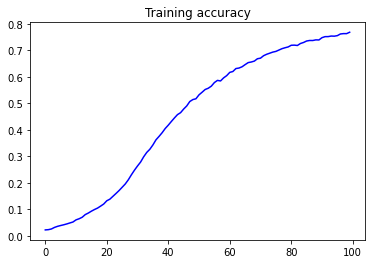

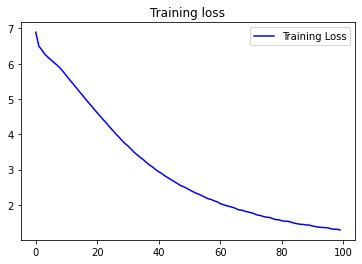

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [0]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# FTC: Note that  maxlen=max_sequence_len-1
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope your tongue tied still with stand to give me so foes bold forgot so deem'd new grow told to give thee thee thee lend thee 'tis twain beauteous twain foes commend brought a lease to have twain ' despair me remain new wrought thee all alone must behold write true thine change thine thine to be bright to sway seen give crave days out days out new ' so so eyes for thee but behold bring me so great verse so stand me to give behind love's cross staineth age ' dyed live hate better grow long grow old rhyme
